In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim

from src.data import CatDataset, getCatDatasetLoaders
from src.engine import Engine
from src.metrics import AccuracyMetricFromProbs

In [14]:
dataset = CatDataset()
loaders = getCatDatasetLoaders(dataset, batch_size=16, test_size=0.2)

In [4]:
classes_dict = {v: k for (k, v) in dataset.classes_dict.items()}
classes_dict

{0: 'bengal',
 1: 'domestic_shorthair',
 2: 'maine_coon',
 3: 'ragdoll',
 4: 'siamese'}

In [5]:
idxs = []
for i in range(100):
    img, lbl = dataset[i]
    if np.argmax(lbl) == len(idxs):
        idxs += [i]
    if len(idxs) == 5: break
idxs

[3, 13, 20, 30, 32]

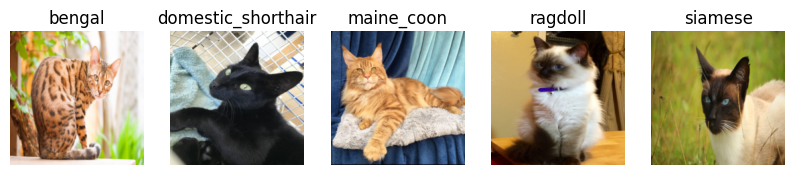

In [6]:
fig, axes = plt.subplots(1, 5, figsize=(10, 5))
for i, idx in enumerate(idxs):
    img, lbl = dataset[idx]
    axes[i].imshow(img.permute((1, 2, 0)).numpy().clip(0, 1)[..., ::-1])
    axes[i].set_title(classes_dict[np.argmax(lbl.numpy())])
    axes[i].axis("off")

In [7]:
lbl_dict = {i:0 for i in range(5)}
for img_path in dataset.images:
    lbl = dataset.classes_dict[img_path.split("/")[0]]
    lbl_dict[lbl] += 1
lbl_dict

{0: 177, 1: 170, 2: 191, 3: 207, 4: 208}

In [15]:
model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding="same"), # (N, 32, 200, 200)
        nn.MaxPool2d(kernel_size=2), # (N, 32, 100, 100)
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding="same"), # (N, 64, 150, 150)
        nn.MaxPool2d(kernel_size=4), # (N, 64, 25, 25)
        nn.Flatten(),
        nn.Linear(in_features=64*25*25, out_features=100),
        nn.Linear(in_features=100, out_features=5),
        nn.Softmax(dim=1)
 )

In [16]:
model.eval()
output = model(img[None, :, :])
output.shape


torch.Size([1, 5])

In [17]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

engine = Engine(
    model=model,
    device="cuda",
    logger_path="log.csv",
    loss_func=nn.MSELoss(),
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    metric=AccuracyMetricFromProbs(n_classes=5)
)

In [18]:
engine.run(loaders["train"], loaders["test"], epochs=1)

Epoch 0


Loss: 0.15472:  10%|█         | 5/48 [00:19<02:49,  3.93s/it]


RuntimeError: [enforce fail at ..\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 485815620 bytes.

In [ ]:
# todo: ресазйнуть все большие картинки до нормальных размеров (до 1к пикселей с сохранением пропорции)
# иначе и на цпу не влезет